# Diabetes Prediction

### Loading Dataset

In [154]:
import pandas as pd

In [155]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### Exploratory Data Analysis

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats

In [158]:
has_diabetes = data[data['diabetes'] == 1]
no_diabetes = data[data['diabetes'] == 0]

#### Average age of Diabetes Person

In [159]:
has_diabetes_age_avg = np.average(has_diabetes['age'])
has_diabetes_std = np.std(has_diabetes['age'])
print(f'The average age of a person that has diabetes is {has_diabetes_age_avg:.2f} with a standard deviation of {has_diabetes_std:.2f}')

The average age of a person that has diabetes is 60.95 with a standard deviation of 14.55


#### Checking for highly correlated features

<AxesSubplot: >

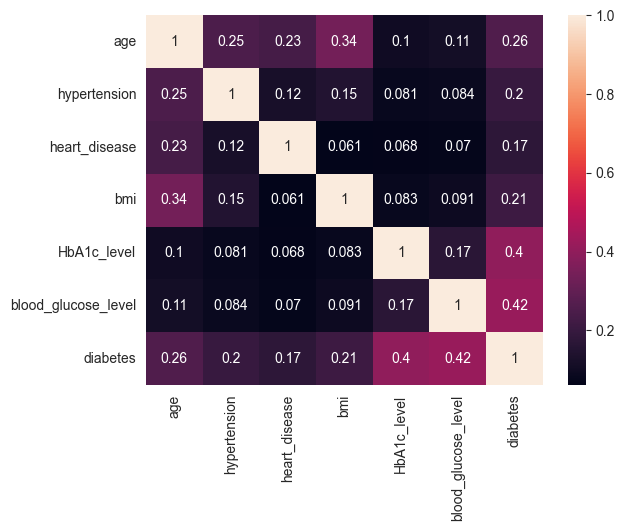

In [160]:
data_num_only = data.select_dtypes(['int64', 'float64'])
data_num_corr = data_num_only.corr()
sns.heatmap(data_num_corr, annot=True)

#### There are no highly correlated features or any signs of colinearity so we can use all of the features to create our model

### Creating the model

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [162]:
X = data.drop(['diabetes', 'gender', 'smoking_history'], axis=1)
y = data['diabetes']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [174]:
param_grid = {
    'penalty' : ['l2'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cholesky']
}

lgr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(estimator=lgr, param_grid=param_grid, cv=5)

In [175]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cholesky']})

In [177]:
print(f'Best Parameters : {grid_search.best_params_}')
print(f'Best Score : {grid_search.best_score_:.2f}')

Best Parameters : {'penalty': 'l2', 'solver': 'lbfgs'}
Best Score : 0.96


In [200]:
LGR = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
LGR.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Model Evaluation

In [224]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#### Applying Cross Validation

In [204]:
folds = KFold(n_splits=5)
cross_val_scores = cross_val_score(estimator=LGR, X=X_train, y=y_train, cv=folds)
print(f'Mean Cross Val Scores : {np.mean(cross_val_scores):.2f}')

Mean Cross Val Scores : 0.96


#### Confusion Matrix

<AxesSubplot: >

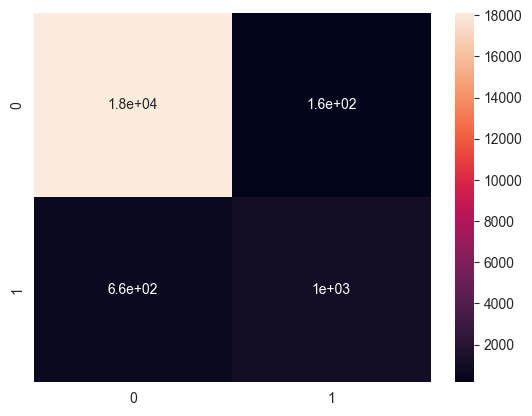

In [223]:
y_pred = LGR.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

#### F1 Score

In [225]:
f1 = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1 score : {f1:.2f}')

F1 score : 0.72
